In [32]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [33]:
actions = [
    'no',
    'thank',
    'sorry'
]

data = np.concatenate([
    np.load('dataset/seq_no_1649083671.npy'),
    np.load('dataset/seq_thank_1649083671.npy'),
    np.load('dataset/seq_sorry_1649083671.npy')
], axis=0)

data.shape

(1469, 30, 100)

In [34]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1469, 30, 99)
(1469,)


In [35]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1469, 3)

In [36]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1322, 30, 99) (1322, 3)
(147, 30, 99) (147, 3)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                41984     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Train on 1322 samples, validate on 147 samples
Epoch 1/200
1312/1322 [============================>.] - ETA: 0s - loss: 14.0669 - acc: 0.4459
Epoch 00001: val_acc improved from -inf to 0.44218, saving model to models/model.h5
1322/1322 [==============================] - 3s 2ms/sample - loss: 13.9871 - acc: 0.4470 - val_loss: 13.3800 - val_acc: 0.4422
Epoch 2/200
1312/1322 [============================>.] - ETA: 0s - loss: 9.6475 - acc: 0.5015
Epoch 00002: val_acc improved from 0.44218 to 0.64626, saving model to models/model.h5
1322/1322 [==============================] - 3s 2ms/sample - loss: 9.5972 - acc: 0.5030 - val_loss: 5.6110 - val_acc: 0.6463
Epoch 3/200
1312/1322 [============================>.] - ETA: 0s - loss: 3.3141 - acc: 0.7264
Epoch 00003: val_acc improved from 0.64626 to 0.77551, saving model to models/model.h5
1322/1322 [==============================] - 3s 2ms/sample - loss: 3.3007 - acc: 0.7262 - val_loss: 1.6261 - val_acc: 0.7755
Epoch 4/200
1312/1322 [============

Epoch 60/200
1312/1322 [============================>.] - ETA: 0s - loss: 5.0443 - acc: 0.5549
Epoch 00060: val_acc did not improve from 0.82993
1322/1322 [==============================] - 10s 8ms/sample - loss: 5.0426 - acc: 0.5552 - val_loss: 9.0854 - val_acc: 0.3537
Epoch 61/200
1312/1322 [============================>.] - ETA: 0s - loss: 3.7641 - acc: 0.5991
Epoch 00061: val_acc did not improve from 0.82993
1322/1322 [==============================] - 7s 5ms/sample - loss: 3.7386 - acc: 0.6006 - val_loss: 3.6637 - val_acc: 0.5442
Epoch 62/200
1312/1322 [============================>.] - ETA: 0s - loss: 3.1679 - acc: 0.6105
Epoch 00062: val_acc did not improve from 0.82993
1322/1322 [==============================] - 9s 7ms/sample - loss: 3.1790 - acc: 0.6104 - val_loss: 3.5539 - val_acc: 0.5578
Epoch 63/200
1312/1322 [============================>.] - ETA: 0s - loss: 3.7586 - acc: 0.6136
Epoch 00063: val_acc did not improve from 0.82993
1322/1322 [==============================] -

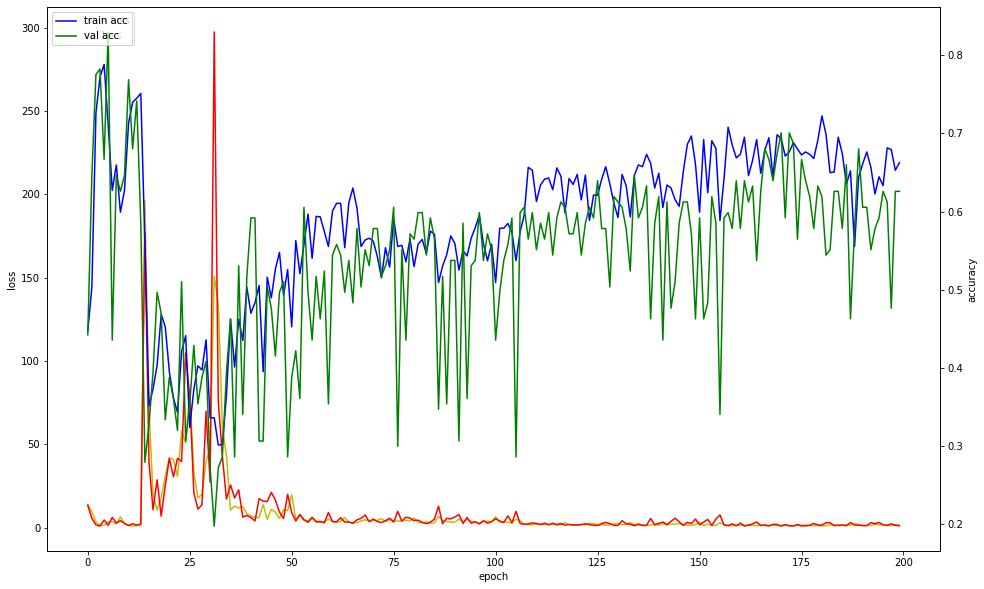

In [38]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [39]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[95, 10],
        [ 2, 40]],

       [[93,  4],
        [12, 38]],

       [[81, 11],
        [11, 44]]])